In [61]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

plt.rcParams["figure.dpi"] = 140  # nicer plots

In [48]:
def load_run_file(path):
    """
    Reads one agent_results_*.json file and returns:
    - df_meta: 1 row summarizing the whole run (runtime, qps, ingest, etc.)
    - df_q:   one row per question (latency breakdown, tokens, cache stats, etc.)
    """
    with open(path, "r") as f:
        raw = json.load(f)

    meta_rows = []
    q_rows = []

    for rec in raw:
        if rec.get("record_type") == "run_meta":
            meta_rows.append({
                "run_type": rec.get("run_type"),
                "summary_total_runtime_s": rec.get("summary_total_runtime_s"),
                "summary_avg_per_question_s": rec.get("summary_avg_per_question_s"),
                "summary_questions": rec.get("summary_questions"),
                "summary_qps": rec.get("summary_qps"),
                "ingest_time_s": rec.get("ingest_time_s"),
                "index_build_time_s": rec.get("index_build_time_s"),
            })
        elif rec.get("record_type") == "question_result":
            cb = rec.get("callback_timing", {}) or {}

            q_rows.append({
                "run_type": rec.get("run_type"),
                "question_number": rec.get("question_number"),
                "question": rec.get("question"),
                "raw_response": rec.get("raw_response", ""),

                # latency breakdown
                "elapsed_time_s": rec.get("elapsed_time"),
                "T_total_s": cb.get("T_total"),
                "T_retrieve_s": cb.get("T_retrieve"),
                "T_reason_s": cb.get("T_reason"),
                "T_generate_s": cb.get("T_generate"),

                # token usage
                "prompt_tokens": cb.get("prompt_tokens"),
                "completion_tokens": cb.get("completion_tokens"),
                "total_tokens": cb.get("total_tokens"),

                # cache stats
                "cache_hits": cb.get("cache_hits", 0),
                "cache_misses": cb.get("cache_misses", 0),
                "first_retrieve_cached": rec.get("first_retrieve_cached"),
                "warm_cache_retrieval_time_ms": rec.get("warm_cache_retrieval_time_ms", 0),

                # dynamic-k retrieval quality (may be missing in Experiment A)
                "k_used": rec.get("k_used"),
                "precision_at_k": rec.get("precision_at_k"),
                "recall_at_k": rec.get("recall_at_k"),
            })

    df_meta = pd.DataFrame(meta_rows)
    df_q = pd.DataFrame(q_rows)

    # normalize warm_cache_retrieval_time_ms: replace NaN with 0 for clean display
    if "warm_cache_retrieval_time_ms" in df_q.columns:
        df_q["warm_cache_retrieval_time_ms"] = df_q["warm_cache_retrieval_time_ms"].fillna(0)

    return df_meta, df_q

In [49]:
def is_valid_structured_answer(raw_response_str: str) -> int:
    """
    Heuristic: treat the answer as 'accurate' if it looks like the agent
    produced structured JSON with query / data_values / computed_values.
    """
    if not isinstance(raw_response_str, str):
        return 0
    needed = [
        "\"query\":",
        "\"data_values\":",
        "\"computed_values\":"
    ]
    return int(all(k in raw_response_str for k in needed))

# SCENARIO A: CACHING ONLY 

## Files: 
- agent_results_baseline_cache.json
- agent_results_optimized_cache.json


In [54]:
meta_A_base, q_A_base = load_run_file("agent_results_baseline_cache.json")
meta_A_opt,  q_A_opt  = load_run_file("agent_results_optimized_cache.json")

# add experiment label
meta_A_base["experiment"] = "cache_only"
meta_A_opt["experiment"]  = "cache_only"
q_A_base["experiment"]    = "cache_only"
q_A_opt["experiment"]     = "cache_only"

# combine baseline+optimized for this experiment
df_meta_A = pd.concat([meta_A_base, meta_A_opt], ignore_index=True)
df_q_A    = pd.concat([q_A_base,    q_A_opt],    ignore_index=True)


In [57]:
cols_question_view = [
    "experiment",
    "run_type",
    "question_number",
    "elapsed_time_s",
    "T_total_s",
    "T_retrieve_s",
    "T_reason_s",
    "T_generate_s",
    "prompt_tokens",
    "completion_tokens",
    "total_tokens",
    "cache_hits",
    "cache_misses",
    "first_retrieve_cached",
    "warm_cache_retrieval_time_ms",
    "k_used",
    "precision_at_k",
    "recall_at_k",
    "accurate",
]

display(
    df_q_A[cols_question_view]
    .sort_values(["run_type","question_number"])
    .reset_index(drop=True)
)

,experiment,run_type,question_number,elapsed_time_s,T_total_s,T_retrieve_s,T_reason_s,T_generate_s,prompt_tokens,completion_tokens,total_tokens,cache_hits,cache_misses,first_retrieve_cached,warm_cache_retrieval_time_ms,k_used,precision_at_k,recall_at_k,accurate
0,cache_only,baseline,1,19.551476,19.5751,0.3699,19.1737,17.4812,3762,863,4625,0,1,False,0.000000,None,0.0,0.0,1
1,cache_only,baseline,2,10.032779,10.0427,0.3822,9.6424,6.1331,9150,722,9872,0,1,False,0.000000,None,0.0,0.0,1
2,cache_only,baseline,3,13.499563,13.5090,0.6394,12.8531,6.9546,8143,910,9053,0,1,False,0.000000,None,0.0,0.0,1
3,cache_only,optimized,1,10.647843,10.6723,0.8757,9.7645,7.8900,4794,831,5625,1,0,False,599.782228,None,0.0,0.0,1
4,cache_only,optimized,2,9.716285,9.7285,0.3605,9.3481,4.7336,9156,761,9917,1,0,False,451.231241,None,0.0,0.0,1
5,cache_only,optimized,3,10.399966,10.4139,0.4020,9.9957,5.3859,8143,922,9065,1,0,False,574.627399,None,0.0,0.0,1


In [58]:
cols_meta_view = [
    "experiment",
    "run_type",
    "summary_total_runtime_s",
    "summary_avg_per_question_s",
    "summary_questions",
    "summary_qps",
    "ingest_time_s",
    "index_build_time_s",
]

display(
    df_meta_A[cols_meta_view]
    .sort_values(["run_type"])
    .reset_index(drop=True)
)

,experiment,run_type,summary_total_runtime_s,summary_avg_per_question_s,summary_questions,summary_qps,ingest_time_s,index_build_time_s
0,cache_only,baseline,43.531726,14.510575,3,0.068915,0.142445,36.330763
1,cache_only,optimized,33.319774,11.106591,3,0.090037,0.138727,38.485296


In [62]:
latency_stats_A = (
    df_q_A
    .groupby(["run_type"])["elapsed_time_s"]
    .quantile([0.5, 0.95])
    .unstack(level=-1)
    .rename(columns={0.5:"p50", 0.95:"p95"})
)

display(latency_stats_A)

,p50,p95
run_type,,
baseline,13.499563,18.946285
optimized,10.399966,10.623055


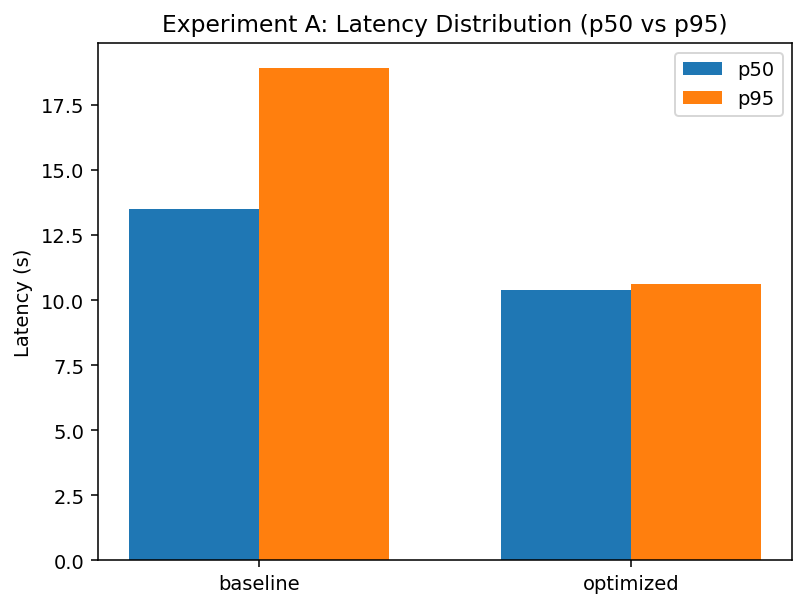

In [67]:
# make it plot-friendly
latency_stats_A_plot = latency_stats_A.reset_index()

# pull arrays
labels = latency_stats_A_plot["run_type"].tolist()        # ['baseline','optimized']
p50_vals = latency_stats_A_plot["p50"].to_numpy(dtype=float)
p95_vals = latency_stats_A_plot["p95"].to_numpy(dtype=float)

x = np.arange(len(labels))  # positions for baseline / optimized
width = 0.35                # bar width

plt.figure()
plt.bar(x - width/2, p50_vals, width, label="p50")
plt.bar(x + width/2, p95_vals, width, label="p95")

plt.xticks(x, labels)
plt.ylabel("Latency (s)")
plt.title("Experiment A: Latency Distribution (p50 vs p95)")
plt.legend()
plt.show()

In [60]:
accuracy_pivot_A = (
    df_q_A
    .groupby(["question_number","run_type"])["accurate"]
    .max()
    .unstack("run_type")
)

display(accuracy_pivot_A)

run_type,baseline,optimized
question_number,,
1,1,1
2,1,1
3,1,1


# SCENARIO B: CACHING + DYNAMIC K

## Files: 
- agent_results_baseline_dynamicK.json
- agent_results_optimized_dynamicK.json

In [75]:
meta_B_base, q_B_base = load_run_file("agent_results_baseline_dynamicK.json")
meta_B_opt,  q_B_opt  = load_run_file("agent_results_optimized_dynamicK.json")

# add experiment label
meta_B_base["experiment"] = "cache + dynamic K"
meta_B_opt["experiment"]  = "cache + dynamic K"
q_B_base["experiment"]    = "cache + dynamic K"
q_B_opt["experiment"]     = "cache + dynamic K"

# combine baseline+optimized for experiment B
df_meta_B = pd.concat([meta_B_base, meta_B_opt], ignore_index=True)
df_q_B    = pd.concat([q_B_base,    q_B_opt],    ignore_index=True)

In [77]:
display(
    df_q_B[cols_question_view]
    .sort_values(["run_type","question_number"])
    .reset_index(drop=True)
)

,experiment,run_type,question_number,elapsed_time_s,T_total_s,T_retrieve_s,T_reason_s,T_generate_s,prompt_tokens,completion_tokens,total_tokens,cache_hits,cache_misses,first_retrieve_cached,warm_cache_retrieval_time_ms,k_used,precision_at_k,recall_at_k,accurate
0,cache + dynamic K,baseline,1,33.658962,33.6889,0.3867,33.2625,27.7404,9918,882,10800,0,1,False,0.000000,12,0.416667,1.0,1
1,cache + dynamic K,baseline,2,11.426954,11.4349,0.3829,11.0359,5.9735,9736,718,10454,0,1,False,0.000000,12,0.083333,1.0,1
2,cache + dynamic K,baseline,3,14.760718,14.7616,0.4522,14.2935,6.1968,8747,877,9624,0,1,False,0.000000,12,0.000000,0.0,1
3,cache + dynamic K,optimized,1,13.502749,13.5263,0.3407,13.1544,7.6064,2839,994,3833,0,1,False,402.195692,5,1.000000,1.0,1
4,cache + dynamic K,optimized,2,9.491008,9.4973,0.3953,9.0888,5.9456,2403,754,3157,0,1,False,400.163889,3,0.000000,0.0,1
5,cache + dynamic K,optimized,3,11.416574,11.4224,0.4226,10.9874,5.8826,2592,894,3486,0,1,False,408.901453,3,0.000000,0.0,1


baseline without dynamic K 
- precision of Q1 = 0.416667 (5 relevant document/12 document retrieved), recall = 1.0 (because retrieved all relevant document as GT)
- precision of Q2 = 0.083333 (1 relevant document/ 12 document retrieved), recall = 1.0 (because retrieved all relevant document as GT)
- precision of Q3 = 0.0 (no relevant document retrieved as GT), recall 0.0 (because retrieved 0 relevant documents as GT)

with dynamic K
- precision of Q1 = 1.0 (5 relevant document/5 document retrieved), recall = 1.0 (because retrieved all relevant document as GT)
- precision of Q2 = 0.0 (no relevant document retrieved as GT), recall = 0.0 (because retrieved 0 relevant document as GT)
- precision of Q3 = 0.0 (no relevant document retrieved as GT), recall 0.0 (because retrieved 0 relevant documents as GT)

In [78]:
display(
    df_meta_B[cols_meta_view]
    .sort_values(["run_type"])
    .reset_index(drop=True)
)

,experiment,run_type,summary_total_runtime_s,summary_avg_per_question_s,summary_questions,summary_qps,ingest_time_s,index_build_time_s
0,cache + dynamic K,baseline,60.326763,20.108921,3,0.049729,0.138430,41.198220
1,cache + dynamic K,optimized,36.104375,12.034792,3,0.083092,0.136134,37.127153


In [79]:
latency_stats_B = (
    df_q_B
    .groupby(["run_type"])["elapsed_time_s"]
    .quantile([0.5, 0.95])
    .unstack(level=-1)
    .rename(columns={0.5:"p50", 0.95:"p95"})
)

display(latency_stats_B)

,p50,p95
run_type,,
baseline,14.760718,31.769138
optimized,11.416574,13.294131


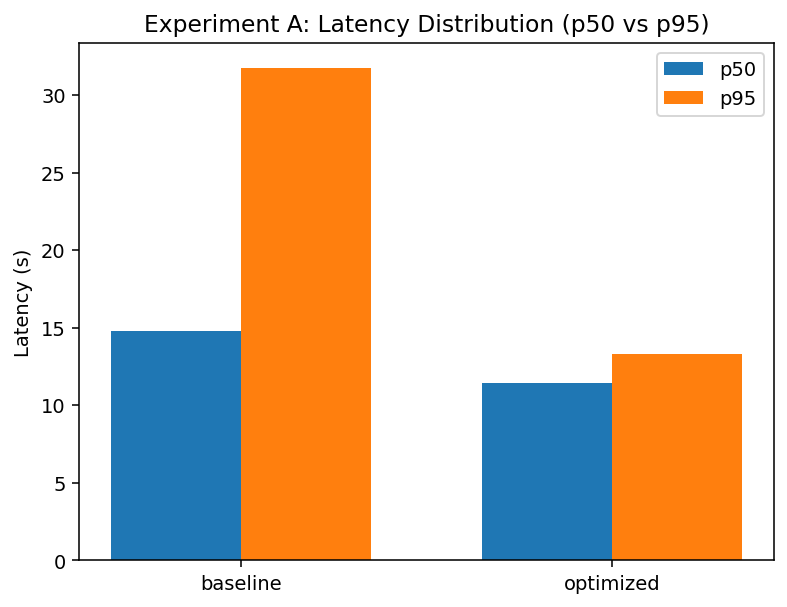

In [82]:
# make it plot-friendly
latency_stats_B_plot = latency_stats_B.reset_index()

# pull arrays
labels = latency_stats_B_plot["run_type"].tolist()        # ['baseline','optimized']
p50_vals = latency_stats_B_plot["p50"].to_numpy(dtype=float)
p95_vals = latency_stats_B_plot["p95"].to_numpy(dtype=float)

x = np.arange(len(labels))  # positions for baseline / optimized
width = 0.35                # bar width

plt.figure()
plt.bar(x - width/2, p50_vals, width, label="p50")
plt.bar(x + width/2, p95_vals, width, label="p95")

plt.xticks(x, labels)
plt.ylabel("Latency (s)")
plt.title("Experiment A: Latency Distribution (p50 vs p95)")
plt.legend()
plt.show()

In [80]:
retrieval_quality_B = (
    df_q_B.groupby("run_type")[["precision_at_k","recall_at_k"]]
    .mean()
    .rename(columns={
        "precision_at_k": "avg_precision_at_k",
        "recall_at_k": "avg_recall_at_k"
    })
)

display(retrieval_quality_B)

,avg_precision_at_k,avg_recall_at_k
run_type,,
baseline,0.166667,0.666667
optimized,0.333333,0.333333


In [81]:
accuracy_pivot_B = (
    df_q_B
    .groupby(["question_number","run_type"])["accurate"]
    .max()
    .unstack("run_type")
)

display(accuracy_pivot_B)

run_type,baseline,optimized
question_number,,
1,1,1
2,1,1
3,1,1
